## Подготовка

Для выполнения первого задания был выбран датасет с сайта Kaggle с данными по стоимости различных сортов вина.

Для текущего проекта была поставлена задача построения модели регресии для цены вина. Целевой метрикой решено было выбрать коэффициент детерминации r^2, который показывает долю объясненной нашей регрессией дисперсии. Метрика была выбрана за её инвариантность к масштабу данных, а так же самое главное - высокую интерпретируемость. Т.к. зачастую сложно оценить значение средней абсолютной ошибки (много это или мало для нашего случая).


In [1]:
pip install --upgrade category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.9 MB/s eta 0:00:00


In [123]:
!pip install optuna > None

In [124]:
# Загрузка библиотек
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from optuna.visualization import plot_optimization_history
import optuna


In [3]:
# Подключение датасета
df = pd.read_csv('/content/WineDataset.csv')

In [4]:
df.head(5)

,Title,Description,Price,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Unit,Characteristics,Per bottle / case / each,Type,ABV,Region,Style,Vintage,Appellation
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,£9.99 per bottle,75CL,Tempranillo,NaN,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,ABV 14.00%,NaN,Rich & Juicy,NV,NaN
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,£15.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,ABV 13.50%,California,Rich & Toasty,2021,Napa Valley
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,£12.49 per bottle,75CL,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,ABV 13.00%,Marlborough,Crisp & Zesty,2022,NaN
3,Louis Latour Mâcon-Lugny 2021/22,We’ve sold this wine for thirty years – and fo...,£17.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,France,10.1,"Peach, Apricot, Floral, Lemon",per bottle,White,ABV 13.50%,Burgundy,Ripe & Rounded,2022,Macon
4,Bread & Butter 'Winemaker's Selection' Pinot N...,Bread & Butter is that thing that you can coun...,£15.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,USA,10.1,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",per bottle,Red,ABV 13.50%,California,Smooth & Mellow,2021,Napa Valley


### Описание данных

* Title: Название или заглавие вина.
* Description: Краткое текстовое описание, содержащее дополнительные сведения о вине.
* Price: Стоимость вина.
* Capacity: Объем или размер винной бутылки.
* Grape: Основной сорт винограда, используемый при изготовлении вина.
* Secondary Grape Varieties: В купаже вина используются дополнительные сорта винограда.
* Closure: Tип укупорки, используемый для бутылки.
* Country: Страна, где производится вино.
* Characteristics: Функция "Характеристики" отражает уникальные и различимые вкусы и ароматы, присутствующие в конкретном вине.
* Per bottle / case / each: количество вина, включенное в стоимость проданной единицы (бутылки, ящика или каждого из них).
* Type: Общая категория вина.
* ABV: Процентное содержание алкоголя в вине.
* Region: Географический регион, где выращивается виноград, используемый для производства вина.
* Style: Эта особенность описывает общее сенсорное восприятие и характеристики вина.
* Vintage: В тот год, когда был собран виноград, из которого было изготовлено вино.
* Appellation: Юридически определенное и охраняемое географическое указание, используемое для определения места выращивания винограда для производства вина.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Title                      1290 non-null   object 
 1   Description                1286 non-null   object 
 2   Price                      1290 non-null   object 
 3   Capacity                   1290 non-null   object 
 4   Grape                      1275 non-null   object 
 5   Secondary Grape Varieties  488 non-null    object 
 6   Closure                    1279 non-null   object 
 7   Country                    1284 non-null   object 
 8   Unit                       1281 non-null   float64
 9   Characteristics            1253 non-null   object 
 10  Per bottle / case / each   1290 non-null   object 
 11  Type                       1285 non-null   object 
 12  ABV                        1281 non-null   object 
 13  Region                     1124 non-null   objec

In [6]:
df.duplicated().sum()

0

На первый взгляд присутствует только один количественный признак, однако это не так, в дальнейшем будет обработано еще несколько из них. Пропусков в датасете не много, большинство из них в колонках Secondary Grape Varieties и Appellation. Явных дупликатов в датасете не обнаружено.

## Обработка количественных признаков

### Процентное содержание алкоголя

In [7]:
# Обработка процентного содержания алкоголя, удаляем не нужные символы из строки
df['ABV'] = df['ABV'].apply(lambda x: str(x).split()[1][0:-1] if isinstance(x, str) else x).astype(float)
fig = go.Figure(data=[go.Histogram(x=df['ABV'])])
fig.show()

Распределение крепости имеет колоколообразную форму, большая часть данных сосредоточена вокруг диапазона 13.3-13.7, что впринципе выглядит реалистично.


### Расчет удельной стоимости вина (целевой переменной)

In [8]:
# Рассмотрим различные тары
df = df.rename(columns = {'Per bottle / case / each':'Packaging'})
fig = go.Figure(data=[go.Histogram(y=df['Packaging'])])
fig.show()

Подавляющее большинство цен указаны за бутылку, для корректного расчета удельной цены оставим только упаковку в виде бутылки.

In [9]:
# Оставим только данные с ценой за бутылку
df = df[df['Packaging'] == 'per bottle']

In [10]:
# Приводим емкость к общей величине
df['Capacity'] = df['Capacity'].replace('75CL', 75)
df['Capacity'] = df['Capacity'].replace('70CL', 70)
df['Capacity'] = df['Capacity'].replace('750ML', 70)
df['Capacity'] = df['Capacity'].replace('500ML', 50)
df['Capacity'] = df['Capacity'].replace('50CL', 50)
df['Capacity'] = df['Capacity'].replace('150CL', 150)
df['Capacity'] = df['Capacity'].replace('300CL', 300)
df['Capacity'] = df['Capacity'].replace('375ML', 37.5)
df['Capacity'] = df['Capacity'].replace('37.5CL', 37.5)
df['Capacity'] = df['Capacity'].replace('1.5LTR', 150)

In [11]:
# Достаем цену из столбца 'Price'
df['Price'] = df['Price'].apply(lambda x: str(x).split()[0][1:]).astype(float)

In [12]:
# Расчет удельной цены
df['U_price'] = df['Price']/df['Capacity']

Text(0.5, 0, 'Цена за сантилитр')

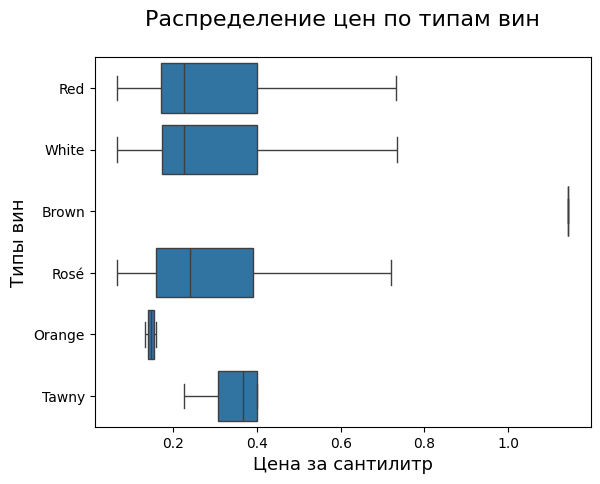

In [13]:
# Строим график ящик с усами
ax = sns.boxplot(x = 'U_price',
                 y = 'Type',
                 data=df,
                 showfliers=False)

ax.set_title('Распределение цен по типам вин' + '\n', fontsize = 16)
ax.set_ylabel('Типы вин', fontsize = 13)
ax.set_xlabel('Цена за сантилитр', fontsize = 13)

Получив удельную цену вина, которую уже можно сравнивать между собой, сразу же появляется желание посмотреть как она распределяется в зависимости от какого-нибудь другого признака. Конкретно в зависимости от типа вина заметно, что красное, белое и розовое имеют приблизительно одинаковое распределение. Только медиана у розового несколько выше. Остальные же типы судя по всему не обладают достаточным числом представителей для построения адекватного графика.

### Обработка типов вина представленных в датасете

In [14]:
type_wine = df['Type'].value_counts()
type_wine = type_wine.to_frame().reset_index().rename(columns = {'Type': 'Count', 'index':'Type'})

fig = px.pie(values = type_wine['Count'],
             names = type_wine['Type'],
             hole = 0.6,
             title = 'Доля каждой категории (типа) вина в выборке')
fig.show()

На круговой диаграме показателен факт, что три 'экзотических' типа вин не обладают достаточным числом примеров в датасете. Так же в таблицу попал вид портвейна.

In [15]:
# Ещё один график зависимости цены, но уже от крепости напитка
plot = px.scatter(df,
                  x = 'U_price',
                  y = 'ABV',
                  color='Type')
plot.update_layout(
    barmode="stack", xaxis_title="Цена за сантилитр вина", yaxis_title="Процентное содржание алкоголя", title = 'Точечное распределение удельной цены и процента алкоголя'
)
plot.show()

Библиотека Plotly позволяет показать точечное распределение двух переменных в разбивке по группам. Какой-то определенной зависимости из графика вывести не удалось

In [16]:
# Обработаем тип вина, т.к. данных по Оранжевому, Коричневому, Смешанному, а так же портвейну малочисленны, упростим классификацию и закодируем One Hot
df['Type'] = df['Type'].replace('Tawny','Red')
df['Type'] = df['Type'].replace('Orange','Red')
df['Type'] = df['Type'].replace('Brown','Red')
df['Type'] = df['Type'].replace('Mixed','Red')

In [17]:
df['Type'].value_counts()

White    582
Red      571
Rosé     122
Name: Type, dtype: int64

Так же обратим внимание на такой признак как общее сенсорное восприятие вина, в него входит целых 16 уникальных меток, интересно узнать как они располагаются в данных.

In [18]:
# Визуализация круговой диаграммы
style_wine = df['Style'].value_counts()
style_wine = style_wine.to_frame().reset_index().rename(columns = {'Style': 'Count', 'index':'Style'})

fig = px.pie(values = style_wine['Count'],
             names = style_wine['Style'],
             hole = 0.6,
             title = 'Общее сенсорное восприятие вина по числу представителей')
fig.show()

Text(0.5, 0, 'Цена за сантилитр')

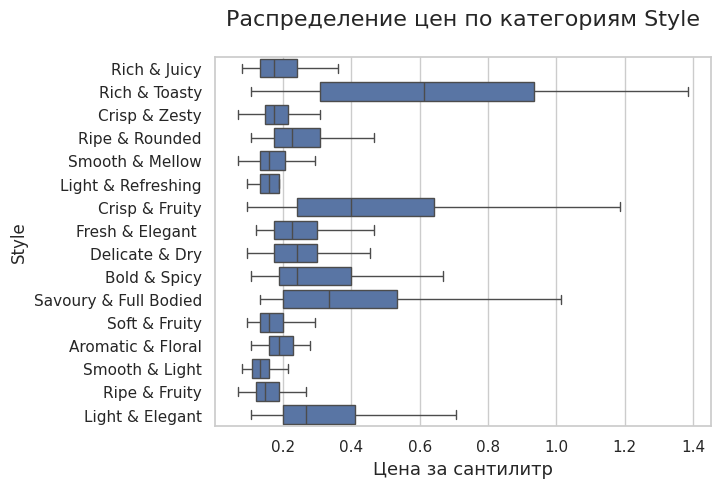

In [19]:
# Строим график ящик с усами
sns.set(style="whitegrid")
ax = sns.boxplot(x = 'U_price',
                 y = 'Style',
                 data=df,
                 showfliers=False)

ax.set_title('Распределение цен по категориям Style' + '\n', fontsize = 16)
ax.set_xlabel('Цена за сантилитр', fontsize = 13)

Наиболее часто встречаемой группой оказалась Savoury & Full Bodied - 12,7%. В целом группы распространены равномерно в пределах 4-8%, сильных перекосов не наблюдается. C точки зрения цены резко выделяются такие категории как Rich & Toasty, Chrisp & Fruity и Savoury & Full Bodied. У них больший разброс значений, правая граница распределения имеет длинный хвост в сторону высоких цен, а так же большее значение медианы.

In [20]:
# Закодируем бинарным кодом признак Style
bin = ce.BinaryEncoder()
bin.fit(df['Style'])
df = df.join(bin.transform(df['Style']))
df = df.drop(columns = {'Style'})

In [21]:
# А так же dummy кодированием признак Type
df = pd.get_dummies(df, columns=['Type'], prefix='Type')
df.head(5)

,Title,Description,Price,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Unit,Characteristics,...,Appellation,U_price,Style_0,Style_1,Style_2,Style_3,Style_4,Type_Red,Type_Rosé,Type_White
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,9.99,75.0,Tempranillo,NaN,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",...,NaN,0.133200,0,0,0,0,1,1,0,0
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,15.99,75.0,Chardonnay,NaN,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",...,Napa Valley,0.213200,0,0,0,1,0,0,0,1
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,12.49,75.0,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",...,NaN,0.166533,0,0,0,1,1,0,0,1
3,Louis Latour Mâcon-Lugny 2021/22,We’ve sold this wine for thirty years – and fo...,17.99,75.0,Chardonnay,NaN,Natural Cork,France,10.1,"Peach, Apricot, Floral, Lemon",...,Macon,0.239867,0,0,1,0,0,0,0,1
4,Bread & Butter 'Winemaker's Selection' Pinot N...,Bread & Butter is that thing that you can coun...,15.99,75.0,Pinot Noir,NaN,Natural Cork,USA,10.1,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",...,Napa Valley,0.213200,0,0,1,0,1,1,0,0


### Год сбора урожая

In [22]:
# Значение NV означает что у вина нет конкретного года сбора винограда, используем его чтобы 'заткнуть пропуски'
df['Vintage'] = df['Vintage'].fillna('NV')

# Комбинированные года решено было привести к общему формату (взята первая дата)
def process_year(year):
    if '/' in year:
        return year.split('/')[0]
    else:
        return year

# Применение функции к столбцу
df['Vintage'] = df['Vintage'].apply(process_year)

In [23]:
vintage = df.groupby('Vintage').agg({'U_price': 'mean'})
vintage = vintage.reset_index()

In [24]:
# Визуализация цен по годам
fig = go.Figure()
fig.add_trace(go.Bar(
                     x = vintage['Vintage'],
                     y = vintage['U_price']
                     ))

fig.update_layout(
    barmode="stack",
    xaxis_title="Год сбора урожая",
    yaxis_title="Средняя цена за сантилитр",
    title="Средняя цена вина по годам"
)
fig.show()

Интересную картину показывает график средней цены от года сбора винограда. Заметна небольшая тенденция к возрастанию цены с годами (что абсолютно ожидаемо), но так же присутствуют и резкие всплески в 2005, 2008, 2012, 2015 году. Видимо в эти года были какие-то особые погодные условия, что сказалось на вкусе (Было бы здорово если модель это выявит), либо же в эти года было поизведено в целом меньше данного товара.

## Обработка категориальных признаков

In [25]:
# Строим список самых популярных вкусов
all_taste = []

# Проходим по каждой строке датафрейма, разделяем строку на навыки
for i in df['Characteristics']:
    if isinstance(i, str):
        top_taste = [i.strip() for i in i.split(',')]
        all_taste.extend(top_taste)

taste_df = pd.DataFrame({'Characteristic': all_taste})

# Посчитаем частоту встречаемости каждого навыка
taste_df = taste_df['Characteristic'].value_counts().reset_index()
taste_df.columns = ['Characteristic', 'Count']
taste_df = taste_df[taste_df['Characteristic'] != '']
taste_df = taste_df.dropna()
taste_df = taste_df.sort_values(by='Count', ascending=False)
taste_df.reset_index()

# Выводим топ-3 вкусов
taste_df.head(3)

,Characteristic,Count
0,Vanilla,259
1,Green Apple,243
2,Peach,243


In [26]:
# Поскольку в стобце Characteristics указаны уникальные вкусовые характеристики вин в порядке
# выраженности, выделим первые 3 характерные черты у каждого вина
for i in range(len(df)):
  try:
    df.loc[i, 'Char_1'] = df.loc[i, 'Characteristics'].split(', ')[0]
    df.loc[i, 'Char_2'] = df.loc[i, 'Characteristics'].split(', ')[1]
    df.loc[i, 'Char_3'] = df.loc[i, 'Characteristics'].split(', ')[2]
  except: None

In [27]:
df.isna().sum()

Title                          0
Description                    3
Price                          0
Capacity                       0
Grape                          8
Secondary Grape Varieties    793
Closure                        0
Country                        0
Unit                           3
Characteristics               30
Packaging                      0
ABV                            3
Region                       159
Vintage                        0
Appellation                  635
U_price                        0
Style_0                        0
Style_1                        0
Style_2                        0
Style_3                        0
Style_4                        0
Type_Red                       0
Type_Rosé                      0
Type_White                     0
Char_1                        41
Char_2                        41
Char_3                        47
dtype: int64

In [28]:
# Заменим пропуски популярными вкусами
df['Char_1'] = df['Char_1'].fillna(taste_df.loc[0, 'Characteristic'])
df['Char_2'] = df['Char_2'].fillna(taste_df.loc[1, 'Characteristic'])
df['Char_3'] = df['Char_3'].fillna(taste_df.loc[2, 'Characteristic'])

In [29]:
taste_df = taste_df.head(20)

In [30]:
fig = px.bar(
    taste_df, y="Count", x="Characteristic", text_auto=True
)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside")
fig.update_layout(xaxis_title="Уникальный вкус в вине",
                  yaxis_title="Количество вин с этим вкусом",
                  title = 'Самые часто встречаемые вкусы')
fig.show()

In [31]:
fig = px.histogram(
    df,
    x="Char_1",
    y="U_price",
    barmode="group",
    histfunc="avg",
)
fig.update_layout(xaxis_title="Первый уникальный вкус в вине", yaxis_title="Средняя удельная цена", title = 'Распределение цен в зависимости от первого вкуса')
fig.show()

В целом большинство характеристик находятся в одном диапазоне, выделяются только 2: Кофейное вино и Кондитерское. Интересный вывод, посмотрим на те характеристики которые указаны на втором и третьем месте.

In [32]:
fig = px.histogram(
    df,
    x="Char_2",
    y="U_price",
    barmode="group",
    histfunc="avg",
)
fig.update_layout(xaxis_title="Второй уникальный вкус в вине", yaxis_title="Средняя удельная цена", title = 'Распределение цен в зависимости от второго вкуса')
fig.show()

In [33]:
fig = px.histogram(
    df,
    x="Char_3",
    y="U_price",
    barmode="group",
    histfunc="avg",
)
fig.update_layout(xaxis_title="Третий уникальный вкус в вине", yaxis_title="Средняя удельная цена", title = 'Распределение цен в зависимости от третьего вкуса')
fig.show()

In [34]:
# Инициализация LabelEncoder
label_encoder = LabelEncoder()

In [ ]:
# Кодируем год сбора label_encoder т.к. переменная имеет порядковый характер
df['Vintage'] = label_encoder.fit_transform(df['Vintage'])
df.head(5)

In [36]:
# Информацию пробке/крышке так же кодируем
df['Closure'] = label_encoder.fit_transform(df['Closure'])

In [37]:
# Заполним пропуски в странах
df['Country'] = df['Country'].fillna('Other')

In [38]:
# Соберем список со странами, где меньше 10 экземпляров
tr = df['Country'].value_counts().to_frame()
tr = tr.reset_index()
tr = tr[tr['Country']<=10]
tr_list = tr['index'].to_list()
tr_list

['Austria',
 'Germany',
 'Greece',
 'Hungary',
 'Moldova',
 'Romania',
 'Lebanon',
 'Georgia',
 'Scotland',
 'Serbia',
 'Slovenia',
 'Mexico',
 'United Kingdom',
 'Bulgaria']

In [39]:
# Заменим мало представленные страны меткой Other, на основании того, что это действительно малопопулярные регионы для экспорта вин
for country in tr_list:
  df['Country'] = df['Country'].replace(country, 'Other')

In [40]:
Country = df['Country'].value_counts()
Country = Country.to_frame().reset_index().rename(columns = {'Country': 'Count', 'index':'Country'})

fig = px.pie(values = Country['Count'],
             names = Country['Country'],
             hole = 0.6,
             title = 'Доля стран экспортеров вин в датасете')
fig.show()

Французские вина составляют целых 39,1% выборки, следущими идут Италия и Испания. Графа Other не привышает 4% следовательно такая вольная группировка стран с низким процентом, не станет критичной для дальнейшей модели.

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1279 entries, 0 to 1289
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Title                      1279 non-null   object 
 1   Description                1276 non-null   object 
 2   Price                      1279 non-null   float64
 3   Capacity                   1279 non-null   float64
 4   Grape                      1271 non-null   object 
 5   Secondary Grape Varieties  486 non-null    object 
 6   Closure                    1279 non-null   int64  
 7   Country                    1279 non-null   object 
 8   Unit                       1276 non-null   float64
 9   Characteristics            1249 non-null   object 
 10  Packaging                  1279 non-null   object 
 11  ABV                        1276 non-null   float64
 12  Region                     1120 non-null   object 
 13  Vintage                    1279 non-null   int64

In [42]:
# Удалим мало полезные столбцы и столбцы с большим числом пропусков
df = df.drop(columns = {'Title', 'Capacity', 'Secondary Grape Varieties', 'Description', 'Packaging', 'Price'})

In [43]:
df

,Grape,Closure,Country,Unit,Characteristics,ABV,Region,Vintage,Appellation,U_price,...,Style_1,Style_2,Style_3,Style_4,Type_Red,Type_Rosé,Type_White,Char_1,Char_2,Char_3
0,Tempranillo,0,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",14.0,NaN,21,NaN,0.133200,...,0,0,0,1,1,0,0,Vanilla,Blackberry,Blackcurrant
1,Chardonnay,0,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",13.5,California,18,Napa Valley,0.213200,...,0,0,1,0,0,0,1,Vanilla,Almond,Coconut
2,Sauvignon Blanc,1,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",13.0,Marlborough,19,NaN,0.166533,...,0,0,1,1,0,0,1,Tropical Fruit,Gooseberry,Grapefruit
3,Chardonnay,0,France,10.1,"Peach, Apricot, Floral, Lemon",13.5,Burgundy,19,Macon,0.239867,...,0,1,0,0,0,0,1,Peach,Apricot,Floral
4,Pinot Noir,0,USA,10.1,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",13.5,California,18,Napa Valley,0.213200,...,0,1,0,1,1,0,0,Smoke,Black Cherry,Cedar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,Chenin Blanc,0,France,9.4,"Quince, Green Apple, Lemon, Pear",12.5,Loire,18,Vouvray,0.159867,...,1,1,0,1,0,0,1,Vanilla,Green Apple,Peach
1286,Pinot Noir,1,New Zealand,9.8,"Floral, Raspberry, Red Cherry, Strawberry",13.0,Nelson,18,NaN,0.186533,...,1,0,0,1,0,1,0,Vanilla,Green Apple,Peach
1287,Cabernet Sauvignon,1,Australia,10.1,"Vanilla, Blackberry, Blackcurrant, Cedar, Euca...",13.5,South Australia,7,Clare Valley,1.133333,...,1,0,1,1,1,0,0,Vanilla,Green Apple,Peach
1288,Cabernet Sauvignon,0,Australia,10.9,"Black Plum, Blackcurrant, Vanilla",14.5,South Australia,13,Coonawarra,0.506533,...,1,0,1,1,1,0,0,Vanilla,Green Apple,Peach


Рассмотрим оставшиеся пропуски в данных. Много пропусков в стобце отвечающем за юридически охраняемое географическое указание на место сбора винограда, но с этим врядли что-то удастся сделать. Скорее всего у вин которые имеют пропуск попросту нет этого сертифицированного указания.

In [44]:
# Последние пропуски численных признаков заполним медианой
df['ABV'] = df['ABV'].fillna(df['ABV'].median())
df['Unit'] = df['Unit'].fillna(df['Unit'].median())

<ipython-input-45-dcbf57e39ddf>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



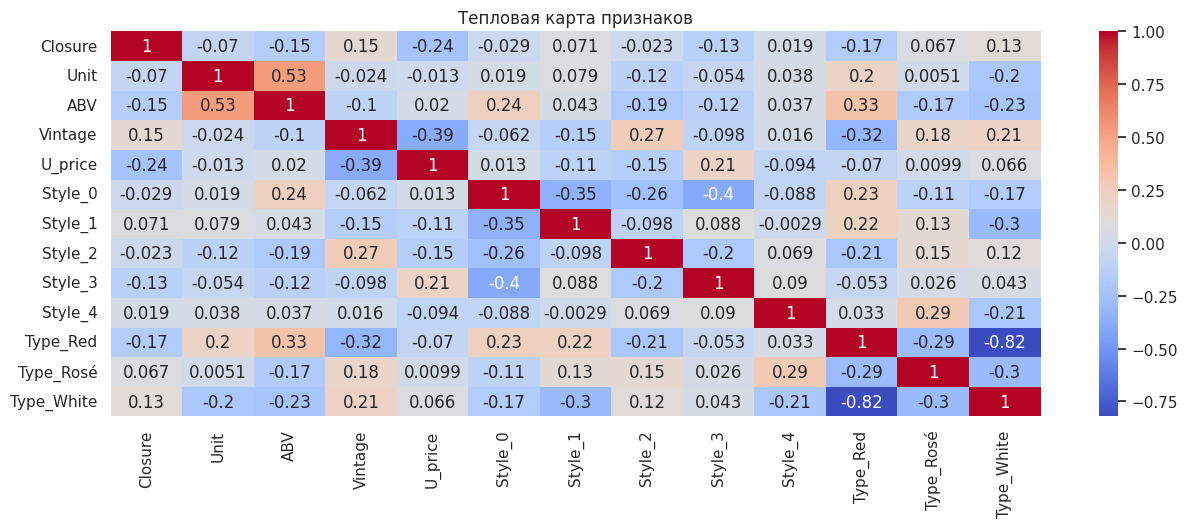

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df.corr(), ax = ax, annot = True, cmap= 'coolwarm')
ax.set_title('Тепловая карта признаков')
plt.show()

## Обучение модели

In [46]:
# Разделение на целевую переменную и признаки
X = df.drop(columns = {'U_price'})
y = df['U_price']

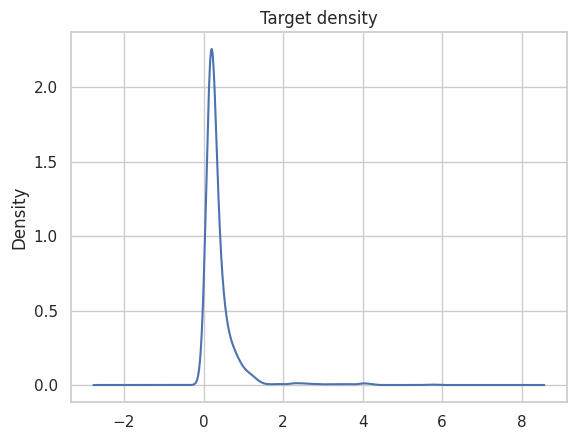

In [47]:
y.plot(kind='kde', title='Target density');

Взглянем на нашу целевую переменную, она имеет распределение гамма формы. Что правильно, так как цена не может быть меньше нуля, а так же по мере возрастания цены уменьшается число представителей.

In [97]:
# Разделим тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [98]:
# Оставшиеся колонки Grape, Country, Style, Char_1, Char_2, Char_3 так же закодируем, но после разделения выборок
encoder = ce.LeaveOneOutEncoder(return_df=True)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

In [80]:
# Произведем стандартизацию признаков

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

Проверим какая модель больше подойдет для наших данных линейная или полиномиальная

In [81]:
for degree in (1, 2, 3):
  polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
  linear_regression = LinearRegression()
  pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  print(f'Точность модели при degree = {degree} составила:', pipeline.score(X_test, y_test))
  print()

Точность модели при degree = 1 составила: 0.4241987524666997

Точность модели при degree = 2 составила: -0.11691746510779444

Точность модели при degree = 3 составила: -76231.59790057142



Таким образом линейная регрессия показала себя лучше чем полиномиальная на текущем наборе данных

In [82]:
# Снова обучим линейную регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

In [83]:
def plotCoefficients(model, columns):
    coefs = pd.DataFrame(model.coef_, columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

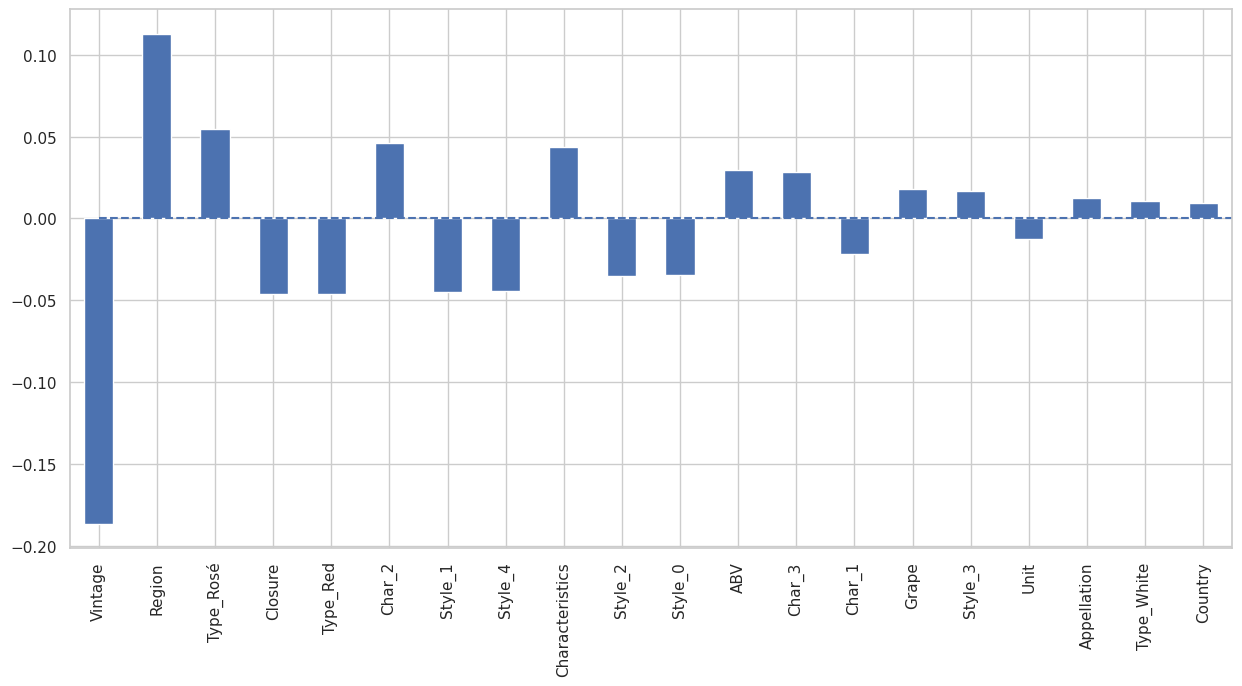

In [84]:
# Визуализируем коэффициенты важности признаков
plotCoefficients(lr, X_train_scaled.columns)

Интересно заметить, что до этого на тепловой карте числовых признаков наибольшую корреляцию давали Vintage и Closure. На данном графике мы видим, что признак Region вырвался на второе место по своему значению.

In [85]:
# Попробуем модель Ridge для предсказания целевой переменной с альфа = 1
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)
y_preds = ridge.predict(X_test_scaled)

print(f'r^2 Ridge: {r2_score(y_test, y_preds)}')

r^2 Ridge: -3.967637966553574


Модели Ridge не удалось выдать хорошего результата

In [86]:
# Попробуем модель GradientBoostingRegressor для построения регрессии
reg = GradientBoostingRegressor(random_state=11, learning_rate = 0.07, n_estimators = 200, max_depth = 1)
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
r2_score(y_test, y_pred)

0.409436682520953

Метрика получилась ниже чем у линейной регрессии, попробуем подобрать гиперпараметры модели

### Подбор гиперпараметров

In [113]:
def objective(trial):

    n_estimators = trial.suggest_int("n_estimators", 1, 300)
    learning_rate = trial.suggest_float("learning_rate", 0, 2)
    max_depth = trial.suggest_int("max_depth", 1, 10)
    classifier_obj = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=11)

    classifier_obj.fit(X_train_scaled, y_train)
    y_pred = classifier_obj.predict(X_test_scaled)
    accuracy = r2_score(y_test, y_pred)
    return accuracy

In [121]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)

[I 2024-02-03 13:34:22,686] A new study created in memory with name: no-name-be5e96d3-76ae-4e9c-a45c-40cee5056a01
[I 2024-02-03 13:34:23,027] Trial 0 finished with value: -0.3085073235364084 and parameters: {'n_estimators': 137, 'learning_rate': 1.310606161032718, 'max_depth': 2}. Best is trial 0 with value: -0.3085073235364084.
[I 2024-02-03 13:34:24,571] Trial 1 finished with value: -0.025426470410597313 and parameters: {'n_estimators': 167, 'learning_rate': 0.02363489665137397, 'max_depth': 10}. Best is trial 1 with value: -0.025426470410597313.
[I 2024-02-03 13:34:24,925] Trial 2 finished with value: 0.2824979216961796 and parameters: {'n_estimators': 230, 'learning_rate': 0.9532850563261139, 'max_depth': 1}. Best is trial 2 with value: 0.2824979216961796.
[I 2024-02-03 13:34:26,692] Trial 3 finished with value: -0.8797204505755369 and parameters: {'n_estimators': 235, 'learning_rate': 1.7987288626986506, 'max_depth': 8}. Best is trial 2 with value: 0.2824979216961796.
[I 2024-02-0

In [122]:
# Построим визуализацию подбора параметров
plot_optimization_history(study)

In [125]:
# Подставим в модель GradientBoostingRegressor подобранные параметры
reg = GradientBoostingRegressor(n_estimators = 18, learning_rate = 0.4441626211928308, max_depth = 1, random_state=11)
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
r2_score(y_test, y_pred)

0.4392058544807864

## Заключение

Таким образом в ходе выполнения работы:
* Определена задача и целевая переменная
* Определена метрика качества
* Была проведена предобработка и разведочный анализ данных
* Реализован пройстейший Feature Engineering, закодированы категориальные переменные
* Опробованы несколько моделей по предсказанию целевой переменной

Наиболее высокие результаты показали Линейная регрессия (R^2 - 0.42) и GradientBoostingRegressor (R^2 - 0.44). В заключение отметим, что достигнутые показатели метрики являются не удовлетворительными (доля объясненной дисперсии меньше 0.5). Причиной может служить недостаточный объем данных. Возможным решением будет служить использование более сложных моделей МО, а так же ансамблевых методов.
